# What is Pytensor?

...

# Who is the audience for this talk?

- Researchers
- Developers


## Takeaways for researchers 

...

## Takeaways for developers

...

# Example sandbox: Sales Forecasting

To motivate the features of Pytensor, I am going to use a specific example centered around timeseries forecasting. 

If you are not interested in this topic, I don't blame you. But I hope to use the example to show:

1. How pytensor helps researchers accelerate their workflow
2. How developers can build on to of Pytensor to make extremely flexible software

## From the researcher perspective

A researcher is going to have a specific model that she's interested in working with. Although there is just one model, it might need to be transformed into many different forms, to do different tasks. For example:

- Pre-estimation checks (simulation, finding solutions)
- Estimation ("taking the model to data") 
- Post-estimation (using the model to make optimal decisions, forecasting, prediction)

The reseracher does *not* care about any of the details about how this happens. She wants to be able to define the function once, then have a nice API that allows all these things to happen.

In addition, we're going to assume she's not an expert in numerical optimizaiton. She'll give her model in the form that is most natural to her, as a researcher in her domain, **not** in the form that is most computationally snappy or numerically stable.

## From the developer perspective

On the developer side, we assume that there is a general form for the model or class of models we're interesting in supporting. There might be a suite of tricks, simplifications, and stabilizations known by the literature that will allow for better performance. 

The developer wants to support the maximum number of models possible, but he also wants performant code. 

....

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from etuples import etuple
from unification import unify, var

import pytensor
import pytensor.tensor as pt
from pytensor.graph import rewrite_graph
from pytensor.graph.fg import FunctionGraph
from pytensor.graph.rewriting.basic import MergeOptimizer, PatternNodeRewriter, out2in


rng = np.random.default_rng(sum(map(ord, "Pytensor at EuroScipy")))

plt.rcParams.update(
    {
        "figure.figsize": (14, 4),
        "figure.dpi": 144,
        "figure.constrained_layout.use": True,
        "axes.spines.top": False,
        "axes.spines.bottom": True,
        "axes.spines.left": True,
        "axes.spines.right": False,
        "axes.grid": True,
        "grid.linewidth": 0.5,
        "grid.linestyle": "--",
    }
)

## The Prophet Model

The prophet model is a time series decomposition model proposed by facebook in ...

Like many time series models, it seeks to decompose an observed signal into a level, trend, and seasonality, so that:

$$ y_t = \text{level}_t + \text{trend}_t + \text{seasonality}_t $$

Unlike other time series models, though, it does this using linear features. So the whole thing collapses back to good old OLS, but with carefully chosen features. 

As a result, it is easy to extend to include additional components. 

## Modeling Sales

Suppose we want to model sales of some widgets as a function of price, which we get to set. We observe the sales (with some noise), as well as the prices (noiselessly, since we set them). 

Maybe our widgets are in higher or lower demand at different times in the year, so there are annual up and down cycles in the data, regardless of the price. Finally, there are economic forces we can't control: the market for our widgets goes up and down of its own accord.

So we can use the prophet model to describe sales, adding in a regression term for the effect of price on sales:

$$ 
\text{sales}_t = \text{level}_t + \text{trend}_t + \text{seasonality}_t + \beta \cdot \text{price}_t 
$$

In [2]:
def create_piecewise_trend(t, t_max, n_changepoints):
    s = pt.linspace(0, t_max, n_changepoints + 2)[1:-1]
    A = (t[:, None] > s) * 1

    return A, s


def create_fourier_features(t, n, p=365.25):
    x = 2 * np.pi * (pt.arange(n) + 1) * t[:, None] / p
    return pt.concatenate((pt.cos(x), pt.sin(x)), axis=1)


def generate_features(t, t_max, n_changepoints=10, n_fourier=6, p=365.25):
    A, s = create_piecewise_trend(t, t_max, n_changepoints)
    X = create_fourier_features(t, n_fourier, p)

    return A, s, X

In [3]:
sales, price, time = pt.dvectors("sales", "price", "time")

A, s, X = generate_features(time, time.max(), p=52, n_fourier=1)

initial_intercept = pt.dscalar("initial_intercept")
initial_slope = pt.dscalar("initial_slope")
trend_changes = pt.dvector("trend_changes")
seasonal_effect = pt.dvector("seasonal_effect")
price_effect = pt.dscalar("price_effect")

params = [
    initial_intercept,
    initial_slope,
    trend_changes,
    seasonal_effect,
    price_effect,
]

intercept = initial_intercept + ((-s * A) * trend_changes[None]).sum(axis=1)
slope = (initial_slope + (A * trend_changes[None]).sum(axis=1)) * time
trend = intercept + slope
price_term = price_effect * price

seasonal = X @ seasonal_effect

expected_sales = trend + seasonal + price_term

In [4]:
pt_rng = pytensor.shared(rng)
next_rng, observation_noise = pt.random.normal(
    scale=1, size=expected_sales.shape, rng=pt_rng
).owner.outputs

observed_sales = expected_sales + observation_noise

sales_fn = pytensor.function(
    [time, price, *params], [expected_sales, observed_sales], updates={pt_rng: next_rng}
)

### Generate Data

In [5]:
true_values = {
    "initial_intercept": 10.0,
    "initial_slope": 0.01,
    "trend_changes": rng.normal(scale=1e-3, size=(10,)),
    "seasonal_effect": np.array([2.0, 1.0]),
    "price_effect": -0.6,
}
T = 52 * 5
time_value = np.arange(T)
obs_prices = rng.normal(loc=10, scale=1, size=(T,))
sales_idx = rng.choice(T, size=(25,), replace=False)

for idx in sales_idx:
    obs_prices[idx : idx + 4] /= 2
prices_obs = np.pad(
    np.convolve(obs_prices, np.full(5, 0.95 ** (np.arange(5))), mode="valid") / 5,
    (2, 2),
    mode="mean",
)

sales_obs = sales_fn(time_value, obs_prices, **true_values)[-1]

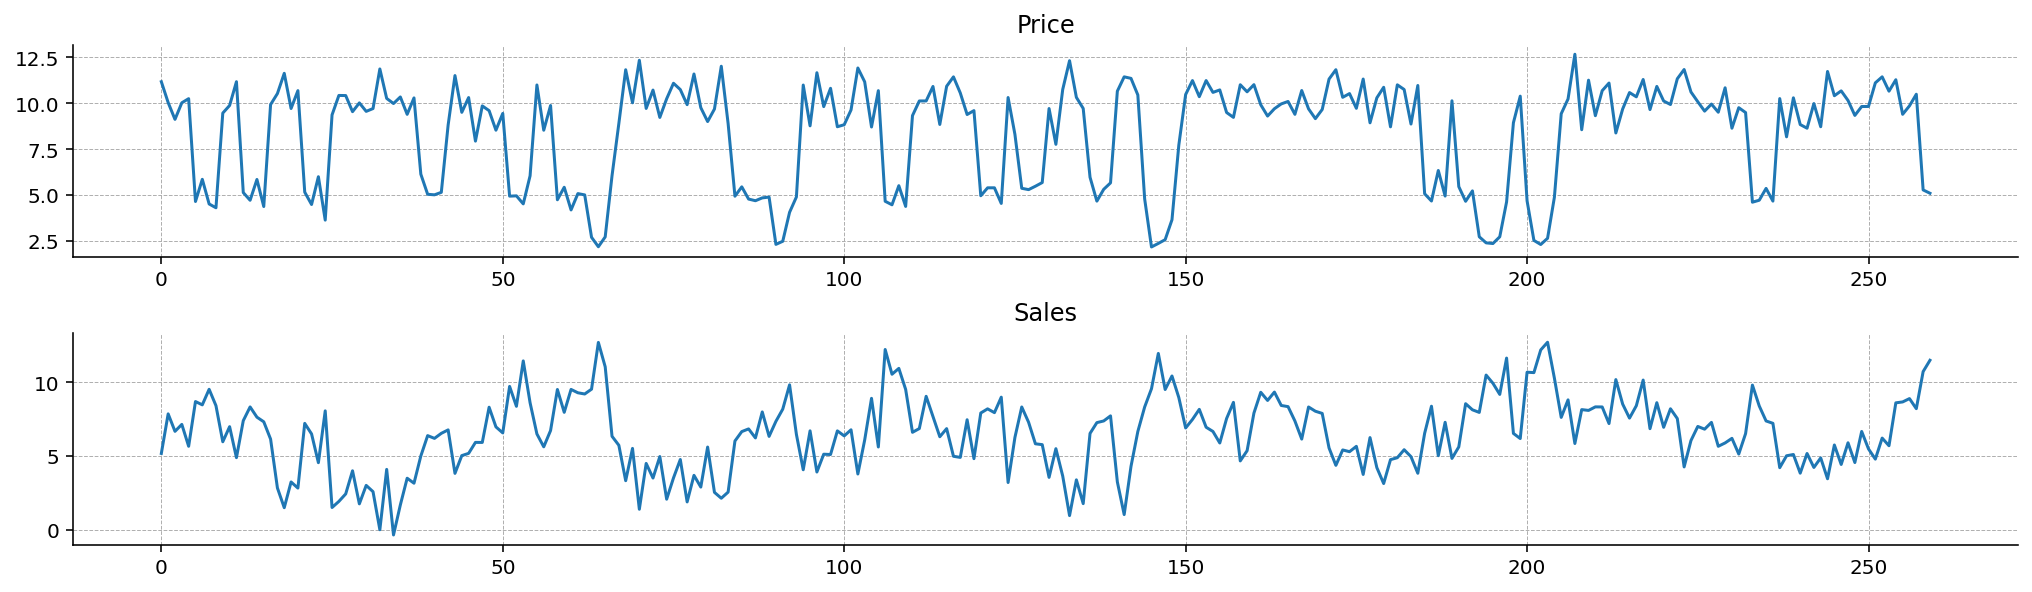

In [6]:
fig, ax = plt.subplots(2, 1)
for axis, data, title in zip(fig.axes, [obs_prices, sales_obs], ["Price", "Sales"]):
    axis.plot(data)
    axis.set(title=title)
plt.show()

## Loss Function and Minimization

To recover the parameters that generated the data, we can choose the parameters of the model to minimize the mean squared error between the estimation of the model and the data.

In [7]:
learning_rate = pt.dscalar("learning_rate")
loss = ((expected_sales - sales) ** 2).mean()

In [8]:
from copy import deepcopy

from IPython.display import clear_output


def sgd(loss, params, init_params):
    optim_params = deepcopy(init_params)

    param_grads = pt.grad(loss, params)
    update_fn = pytensor.function([*params], [loss, *param_grads])

    n_iter = 60_000
    history = np.empty(n_iter)
    start_i = None

    for i in range(n_iter):
        curr_loss, *curr_grads = update_fn(**optim_params)
        lr = max(1e-3 * 0.999**i, 5e-5)
        for key, grad in zip(optim_params.keys(), curr_grads):
            optim_params[key] -= lr * 2 * grad / (np.linalg.norm(grad) + 1e-8)

        history[i] = curr_loss
        if curr_loss < 5 and not start_i:
            start_i = i

        if start_i and (i % 1000 == 0):
            clear_output(wait=True)
            plt.plot(np.arange(start_i, i), history[start_i:i])
            plt.show(block=False)

    return optim_params

In [9]:
from pytensor.graph.replace import graph_replace


loss_w_data = graph_replace(
    loss, {time: time_value, price: prices_obs, sales: sales_obs}
)

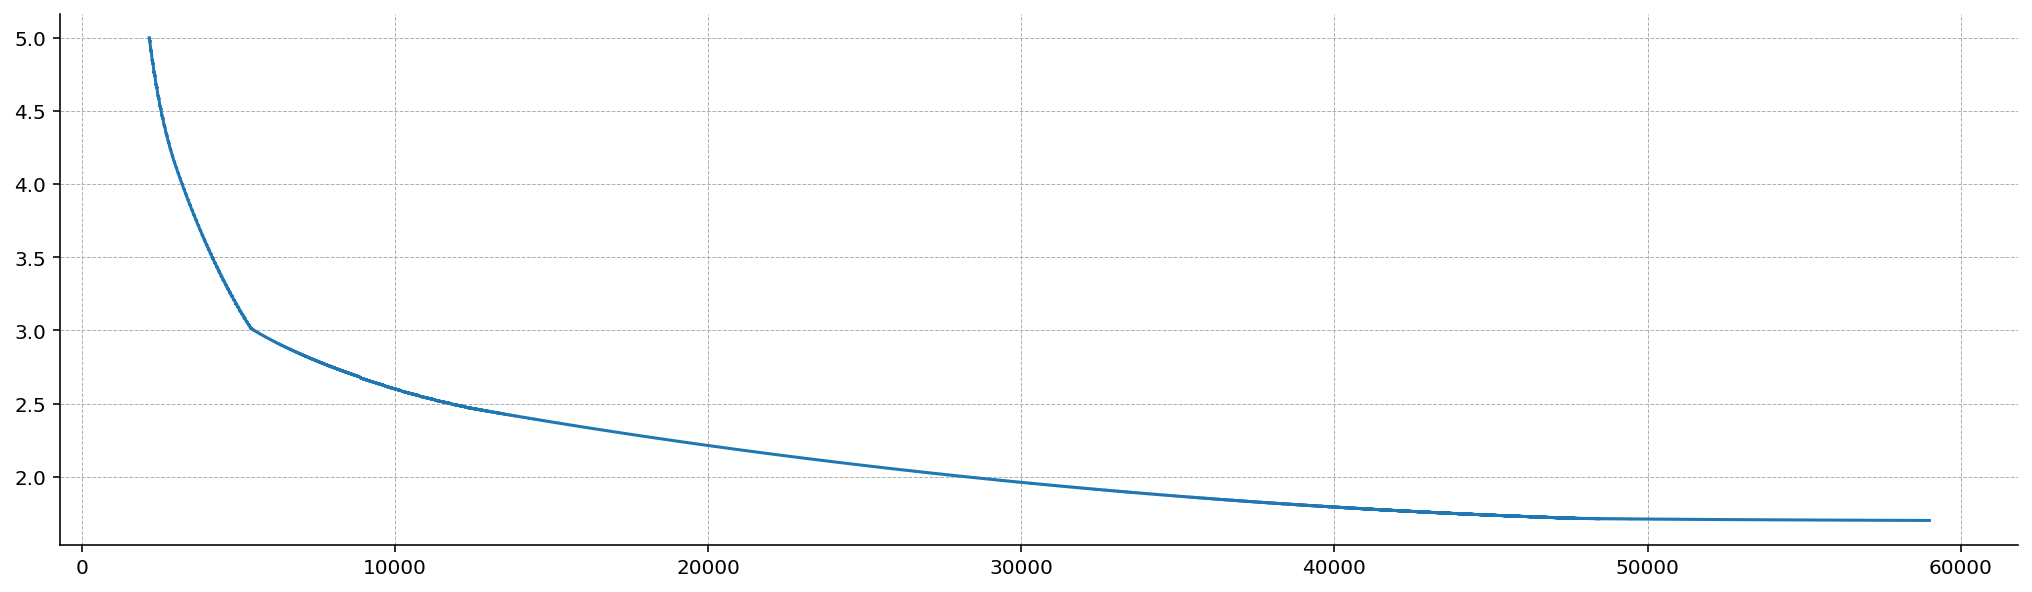

In [10]:
init_params = {
    k: np.random.normal(scale=0.1, size=np.asarray(v).shape)
    for k, v in true_values.items()
}
init_params["initial_intercept"] = sales_obs[0]
init_params["initial_slope"] = np.diff(sales_obs)[1]

optim_params = sgd(loss_w_data, params, init_params)

In [11]:
optim_params

{'initial_intercept': np.float64(11.681570264349684),
 'initial_slope': np.float64(-0.07917642793406518),
 'trend_changes': array([ 0.16561623, -0.11527063,  0.06456953, -0.04333314,  0.04165983,
        -0.02081626, -0.02273469,  0.04687949, -0.0611324 ,  0.06905706]),
 'seasonal_effect': array([1.55111046, 1.06079011]),
 'price_effect': array(-0.76163661)}

In [12]:
true_values

{'initial_intercept': 10.0,
 'initial_slope': 0.01,
 'trend_changes': array([-1.09518728e-04,  1.76953844e-03, -4.74829075e-05,  9.11530126e-04,
        -4.56071393e-04, -7.78430154e-04, -2.32596362e-04,  9.00049221e-05,
        -1.03749028e-03, -2.49939079e-04]),
 'seasonal_effect': array([2., 1.]),
 'price_effect': -0.6}

## Predictions

In [13]:
predicted_sales = sales_fn(time_value, prices_obs, **optim_params)[0]

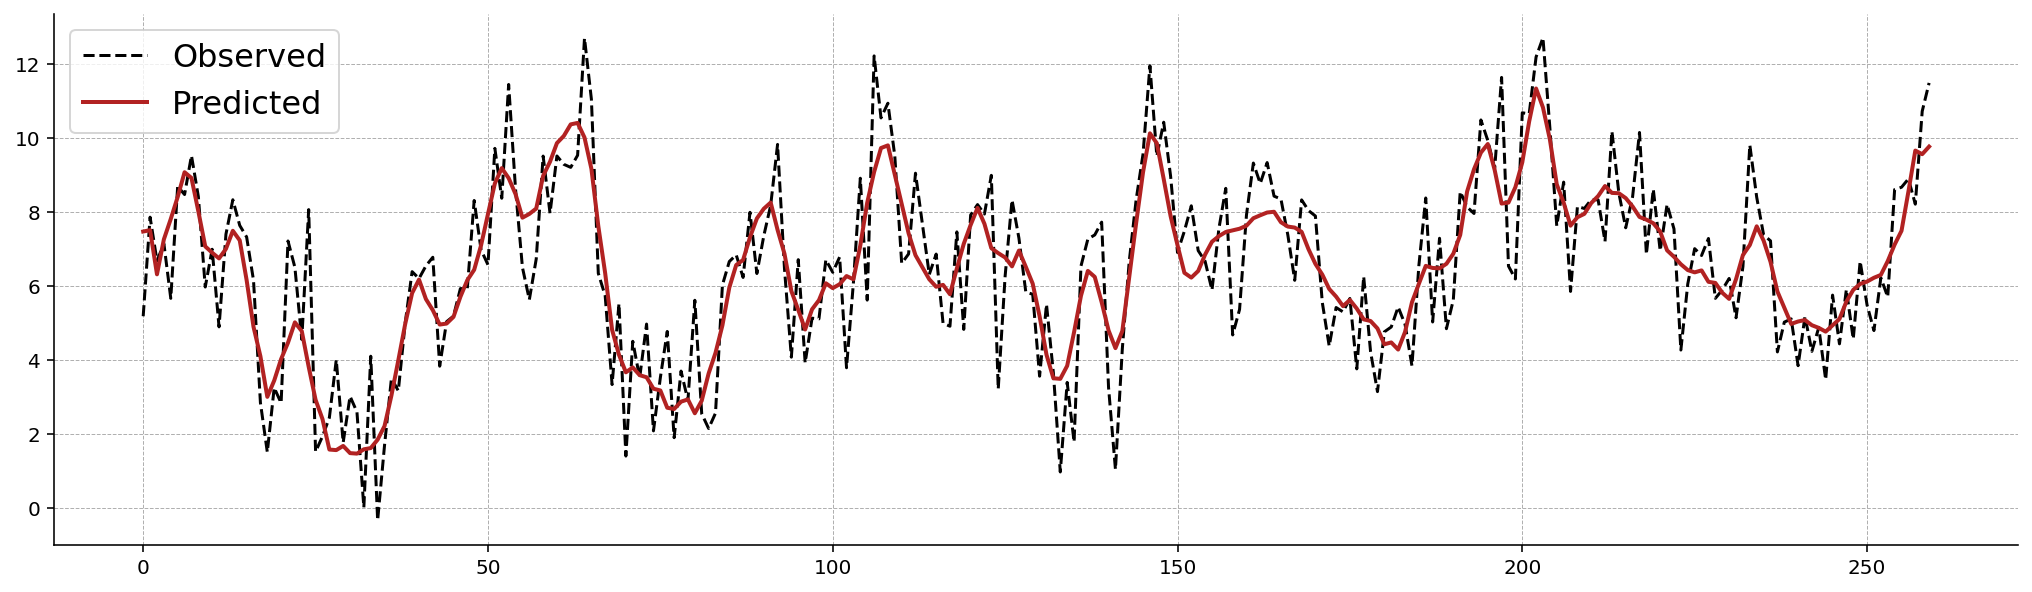

In [14]:
plt.plot(sales_obs, c="k", label="Observed", ls="--")
plt.plot(predicted_sales, c="firebrick", lw=2, label="Predicted")
plt.legend(fontsize=16)
plt.show()

### Simple Graph Manipulation

In [15]:
# Do a causal intervention (Grinch steals christmas for one year)

## Reusing Intermediate Results

### Time Series Decomposition

In [16]:
f_decompose = pytensor.function(
    [time, price, *params], [intercept, slope, trend, seasonal, price_term]
)

In [17]:
component_names = [
    "Intercept",
    "Slope",
    "Trend = Intercept + Slope",
    "Seasonal Effect",
    "Price Effect",
]
components = f_decompose(time_value, prices_obs, **optim_params)

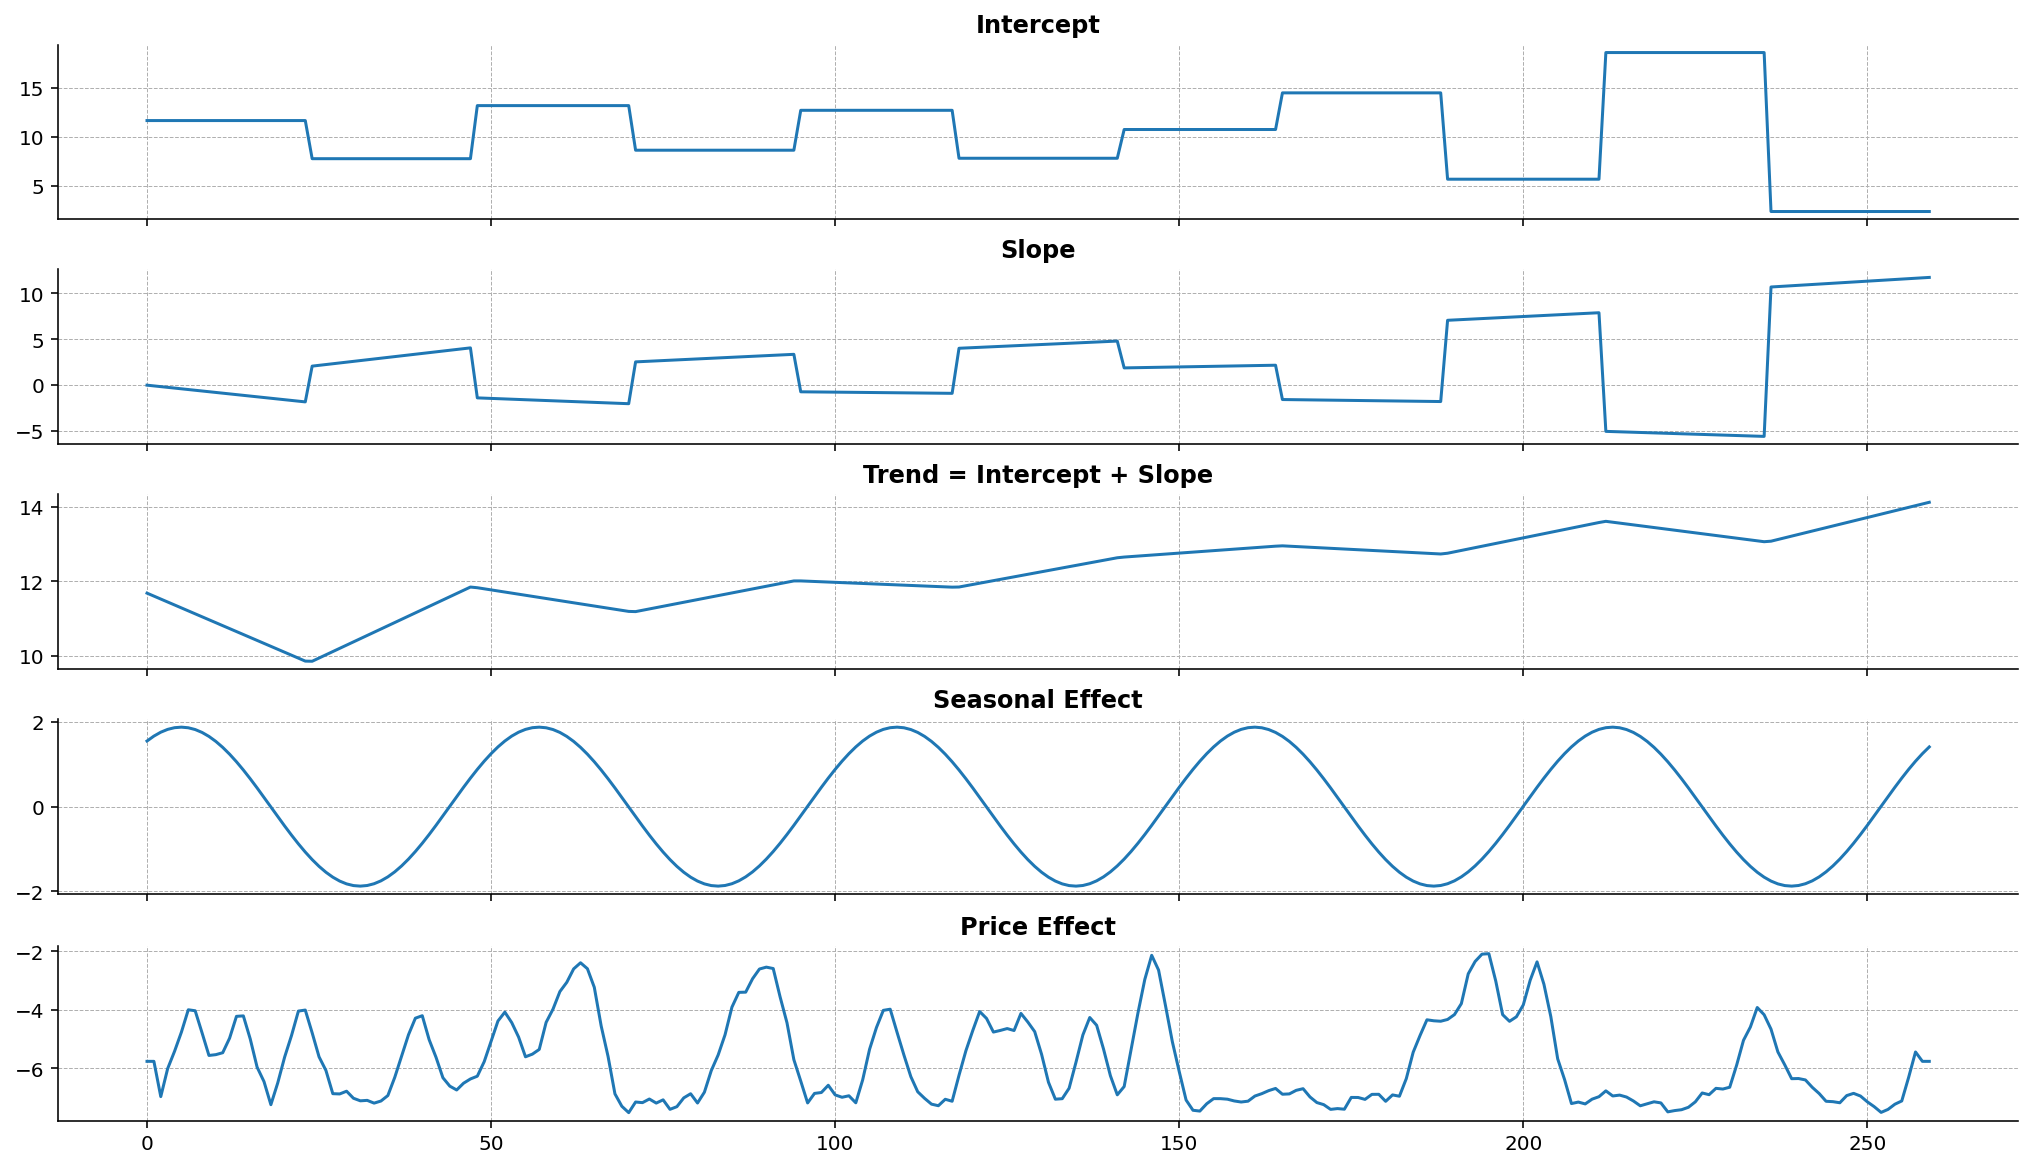

In [18]:
fig, ax = plt.subplots(5, 1, figsize=(14, 8), dpi=144, sharex=True)
for axis, data, name in zip(fig.axes, components, component_names):
    axis.plot(data)
    axis.set_title(name, fontdict={"weight": "bold"})
plt.show()

## "Constrained" Optimization

Often, we might want to restrict a parameter value to be in a certain range. For example, theory says the price effect should be negative -- if prices go up, demand should go down. 

One way to do this is to use an optimization algorithm that can handle boundaries. But we could also use a change of variables. Instead of choosing `price_effect`, we can have the optimizer choose `log(price_effect)`, then replace `price_effect` with `-exp(log(price_effect))` in the objective function. This will force the result to be strictly negative.

In [19]:
log_price_effect = pt.dscalar("log_price_effect")
new_params = [*params[:-1], log_price_effect]
constrained_loss = graph_replace(loss_w_data, {price_effect: -pt.exp(log_price_effect)})

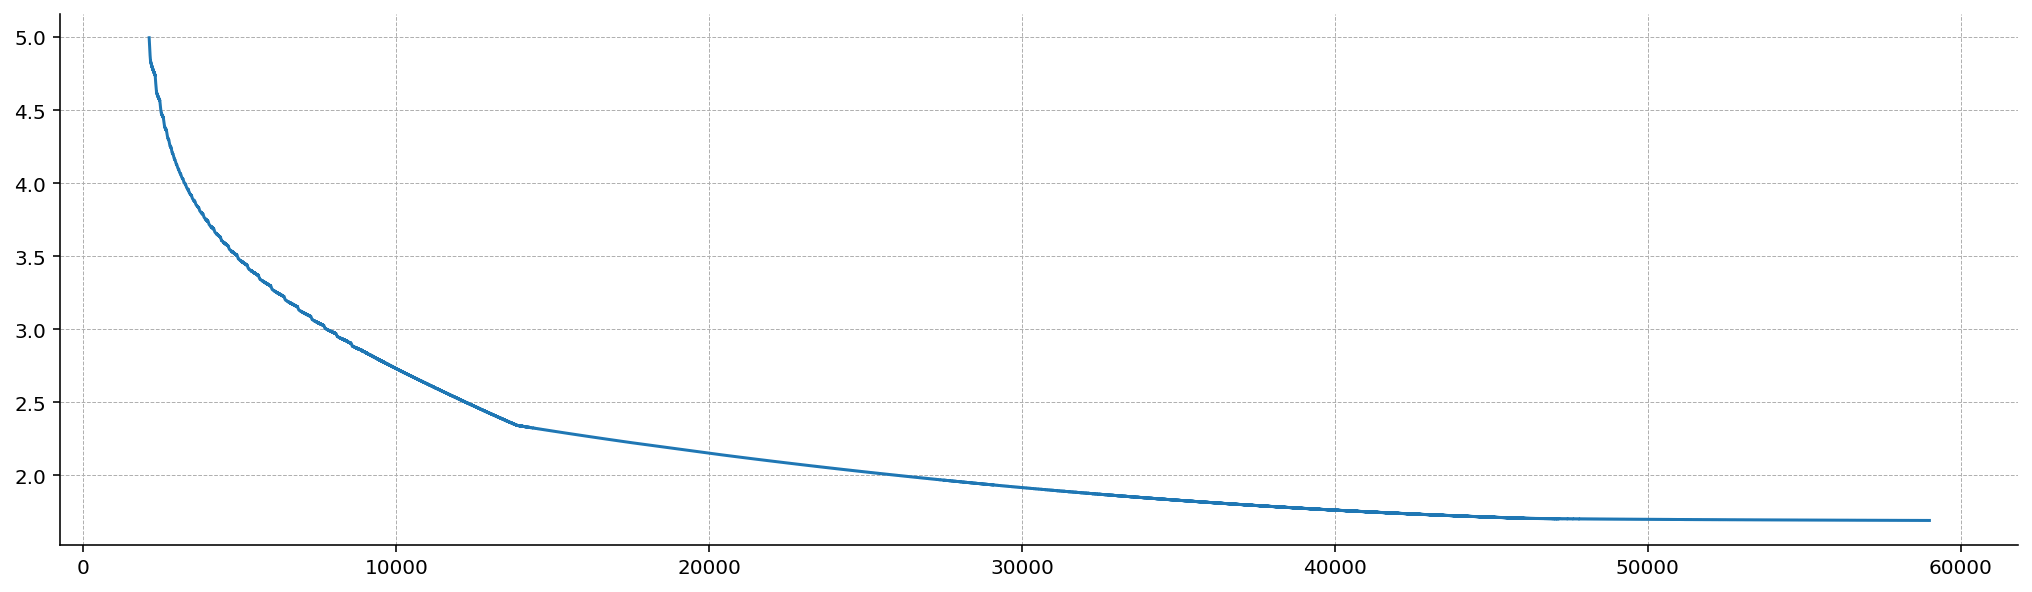

In [20]:
new_init_params = deepcopy(init_params)
new_init_params["log_price_effect"] = init_params["price_effect"]
del new_init_params["price_effect"]

constrained_optim_params = sgd(constrained_loss, new_params, new_init_params)

In [21]:
constrained_optim_params

{'initial_intercept': np.float64(11.524721469217415),
 'initial_slope': np.float64(-0.06844802562518706),
 'trend_changes': array([ 0.15135658, -0.11384178,  0.07178844, -0.05484609,  0.05420304,
        -0.0318336 , -0.01430645,  0.04073184, -0.05693904,  0.06812181]),
 'seasonal_effect': array([1.56786851, 1.09966068]),
 'log_price_effect': array(-0.27037942)}

In [22]:
-np.exp(constrained_optim_params["log_price_effect"])

np.float64(-0.7630899100250035)

### Post Estimation: Choosing Optimal Price

We now have a demand function, which tells us how many widgets we will sell given a price. We can now ask how to set the price to maximimze total profits, given this demand function.

Our profit is just what we make by selling $Q_t$ widgets, minus the cost it took us to "produce" those widgets. Don't take "produce" too seriously -- we might be reselling things, in which case the cost of "production" is the wholesale cost.  

$$
\pi_t = Q_t P_t - Q_t \text{mc}_t = Q_t(P_t - \text{mc}_t)
$$

Where $Q_t$ is the quantity sold, $P_t$ is the unit price, and $\text{mc}_t$ is the marginal cost of production for a single unit.

We seek $P^\star_t$ such that profits are maximized:

$$
\max_{P^\star_t} Q_t(P^\star_t - \text{mc}_t)
$$

The general strategy for solving these is that we take derivaties of the objective function with respect to the controls and set it equal to zero. In this case, thats $\frac{\partial \pi_t}{\partial P_t} = 0$. We then seek $P_t^\star$ such that this equation is true.

Assume we're making a package for this, and we know nothing about the $Q_t$ or $\text{mc}_t$ that a user might provide. We can still symbolically solve this equation in the general case using a root finder

In [23]:
from pytensor.tensor.optimize import root


def find_optimal_P(P, Q, mc):
    pi = (Q * (P - mc)).sum()
    dpi_dP = pt.grad(pi, P)
    P_star, success = root(dpi_dP, P, method="hybr", optimizer_kwargs=dict(tol=1e-8))
    return P_star, success

In [24]:
# Assume constant marginal cost
mc = pt.dscalar("marginal_cost")

optimal_P, success = find_optimal_P(price, expected_sales, mc)
P_star_fn = pytensor.function([time, price, *params, mc], [optimal_P, success])
profit_fn = pytensor.function([price, sales, mc], sales * (price - mc))

In [25]:
P_star, success_flag = P_star_fn(
    time_value, np.zeros_like(time_value), **optim_params, marginal_cost=5.0
)
success_flag

np.False_

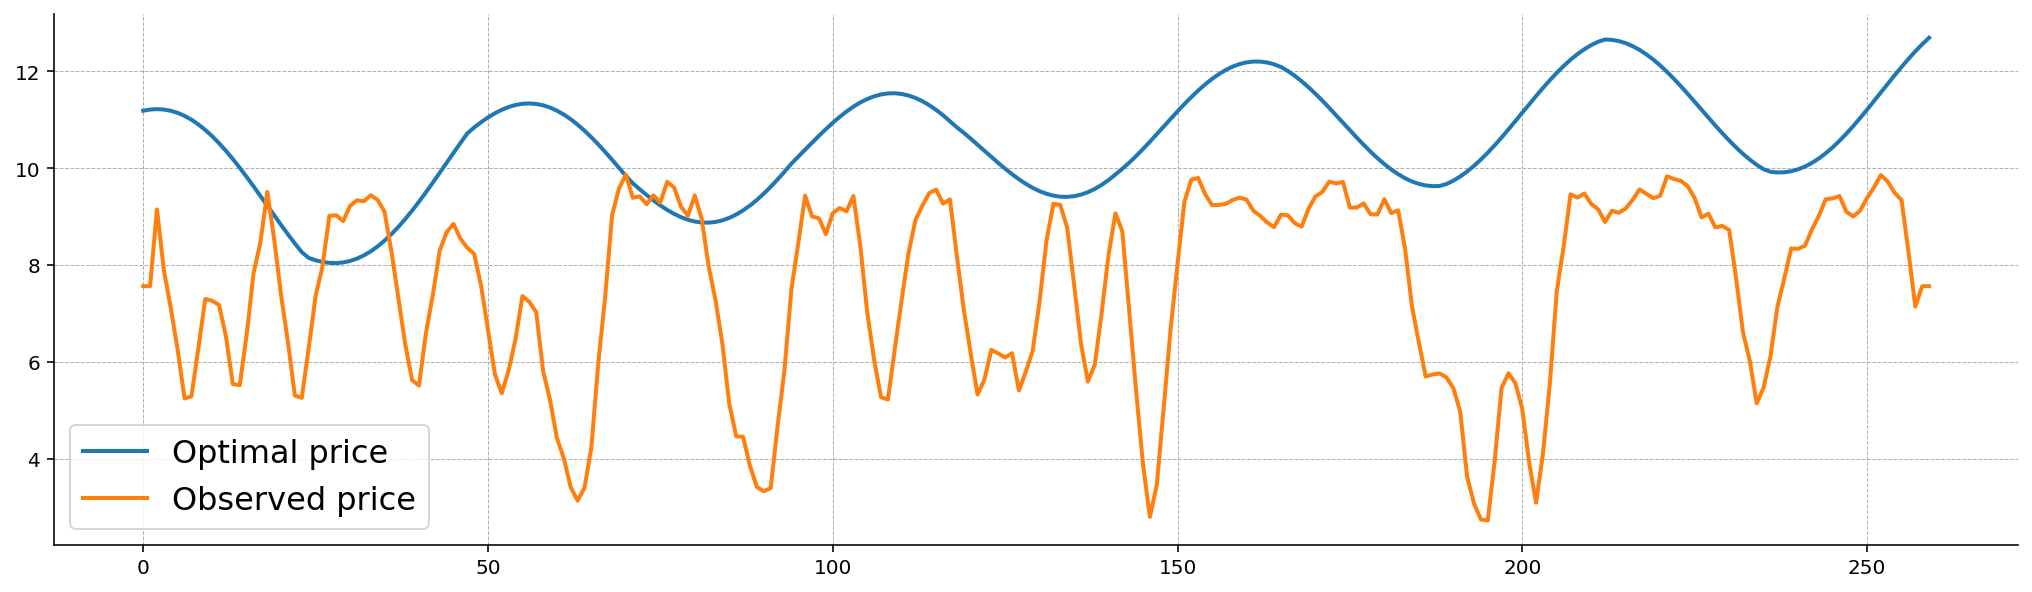

In [26]:
plt.plot(P_star, lw=2, label="Optimal price")
plt.plot(prices_obs, lw=2, label="Observed price")
plt.legend(fontsize=16)
plt.show()

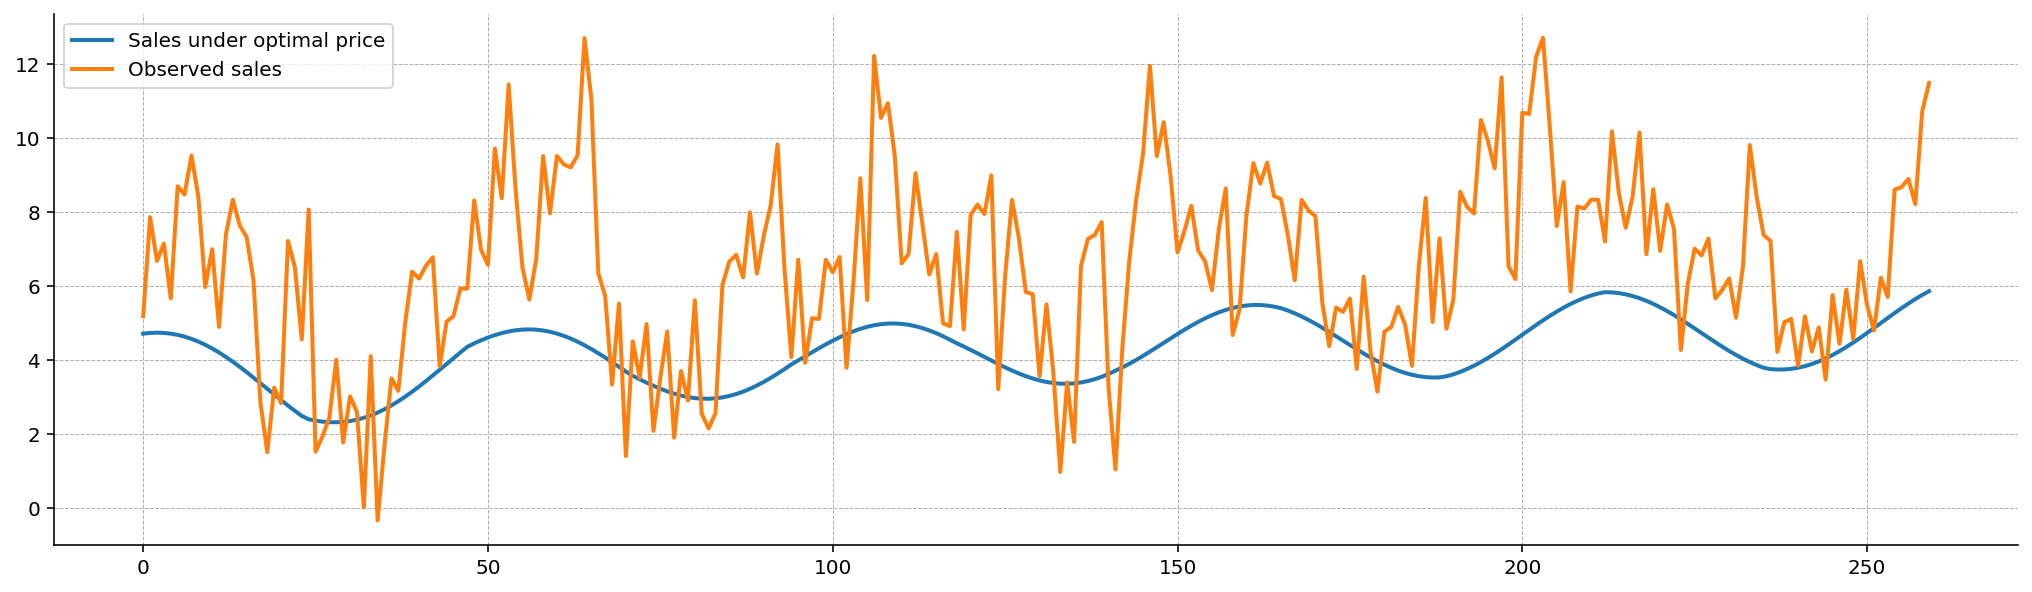

In [27]:
Q_star = sales_fn(time_value, P_star, **optim_params)[0]

plt.plot(Q_star, lw=2, label="Sales under optimal price")
plt.plot(sales_obs, lw=2, label="Observed sales")

plt.legend()

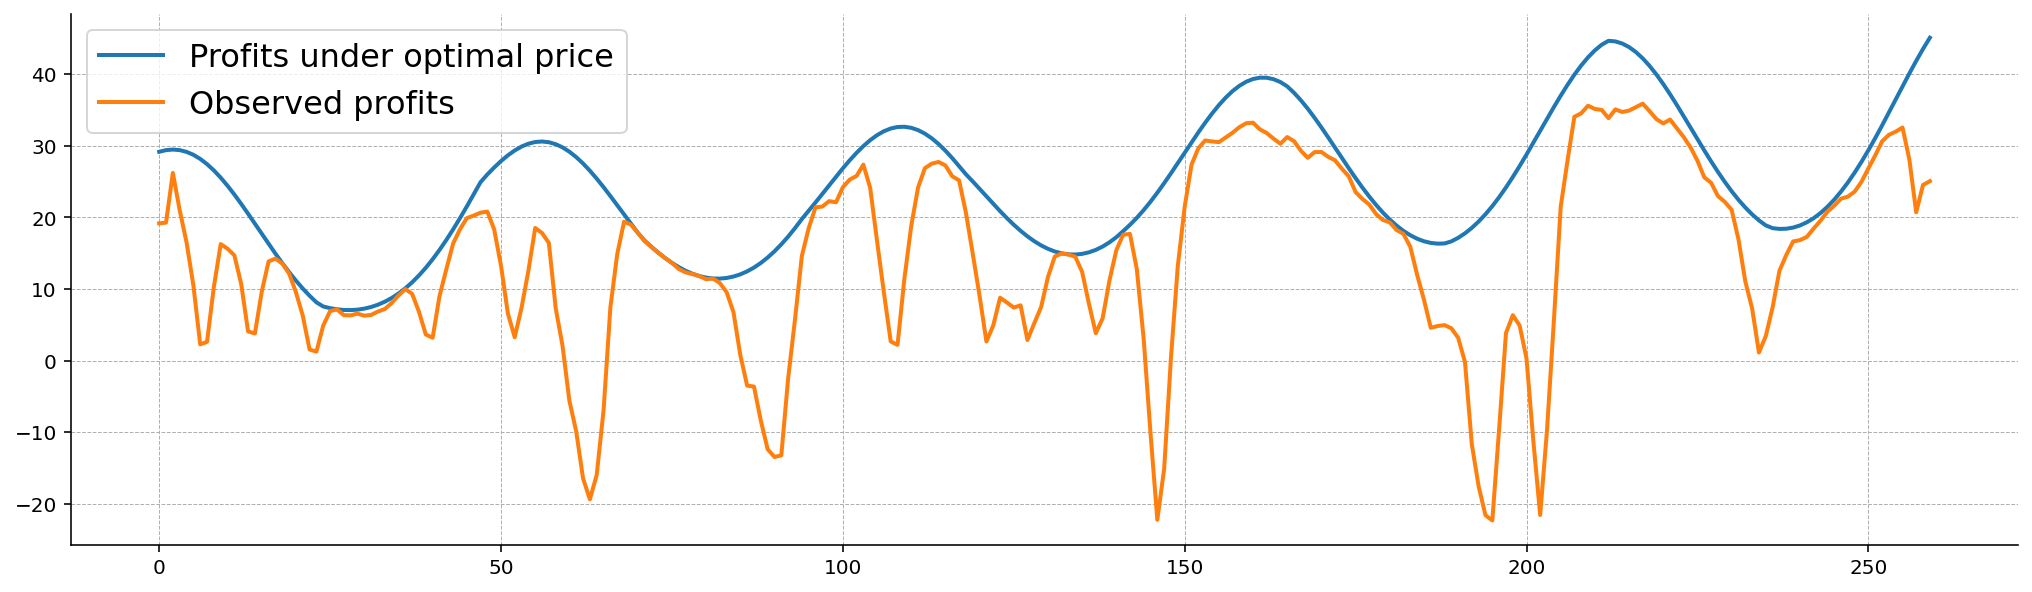

In [28]:
plt.plot(
    profit_fn(P_star, Q_star, marginal_cost=5.0),
    lw=2,
    label="Profits under optimal price",
)
plt.plot(
    profit_fn(
        prices_obs,
        sales_fn(time_value, prices_obs, **optim_params)[0],
        marginal_cost=5.0,
    ),
    lw=2,
    label="Observed profits",
)
plt.legend(fontsize=16)
plt.show()

If you are familiar with numerical optimizers, you know they can be fussy. We'd really like to avoid them if we can. In this case we can, because the demand function is just linear. Bascially, we have:

$$ Q_t =f(t) + \beta P_t $$

Where $f(t) = \text{level}_t + \text{trend}_t + \text{seasonality}_t$

Substituting that into the profit function:

$$
\max_{P_t} \pi_t = (f(t) + \beta P_t) (P_t - \text{mc}_t)
$$


Expand terms:

$$
\max_{P_t} \pi_t = f(t)P_t - f(t) \text{mc}_t + \beta P_t^2 - \beta \text{mc}_t P_t 
$$

Solve for a first-order condition:

$$
\begin{aligned}
\frac{\partial \pi_t}{\partial P_t} &= 0 \Rightarrow  \\
f(t) + 2 \beta P_t - \beta \text{mc}_t &= 0 \\
P_t^\star &= \frac{\beta \text{mc}_t - f(t)}{2\beta}
\end{aligned}
$$

This is a well-known result from Economics 101, giving the optimal price of a monopoly firm that faces a linear demand function.

## Graph Analysis

In [29]:
pi = (expected_sales * (price - mc)).sum()
dpi_dP = pt.grad(pi, price)
expr = rewrite_graph(dpi_dP, include=("canonicalize",))

In [30]:
expr.dprint()

Add [id A]
 ├─ Mul [id B]
 │  ├─ Sub [id C]
 │  │  ├─ price [id D]
 │  │  └─ ExpandDims{axis=0} [id E]
 │  │     └─ marginal_cost [id F]
 │  └─ ExpandDims{axis=0} [id G]
 │     └─ price_effect [id H]
 ├─ ExpandDims{axis=0} [id I]
 │  └─ initial_intercept [id J]
 ├─ Sum{axis=1} [id K]
 │  └─ Mul [id L]
 │     ├─ [[-1.]] [id M]
 │     ├─ ExpandDims{axis=0} [id N]
 │     │  └─ Subtensor{start:stop} [id O]
 │     │     ├─ SetSubtensor{i} [id P]
 │     │     │  ├─ Mul [id Q]
 │     │     │  │  ├─ [0.09090909] [id R]
 │     │     │  │  ├─ [ 0.  1. ... . 10. 11.] [id S]
 │     │     │  │  └─ ExpandDims{axis=0} [id T]
 │     │     │  │     └─ Max{axes=None} [id U]
 │     │     │  │        └─ time [id V]
 │     │     │  ├─ Max{axes=None} [id U]
 │     │     │  │  └─ ···
 │     │     │  └─ -1 [id W]
 │     │     ├─ 1 [id X]
 │     │     └─ -1 [id W]
 │     ├─ Gt [id Y]
 │     │  ├─ ExpandDims{axis=1} [id Z]
 │     │  │  └─ time [id V]
 │     │  └─ ExpandDims{axis=0} [id N]
 │     │     └─ ···
 │

In [31]:
distribute_mul_over_add = PatternNodeRewriter(
    (pt.mul, (pt.add, "x", "y"), "z"),
    (pt.add, (pt.mul, "z", "x"), (pt.mul, "z", "y")),
)

distribute_mul_over_sub = PatternNodeRewriter(
    (pt.mul, (pt.sub, "x", "y"), "z"),
    (pt.add, (pt.mul, "z", "x"), (pt.mul, "z", (pt.neg, "y"))),
)

combine_addition_terms = PatternNodeRewriter(
    (pt.add, (pt.add, "x", "y"), "z", "w", "q", "r", "x"),
    (pt.add, (pt.mul, "x", 2), (pt.add, "y", "z", "w", "q", "r")),
)

distribute_mul_over_add = out2in(distribute_mul_over_add, name="distribute_mul_add")
distribute_mul_over_sub = out2in(distribute_mul_over_sub, name="distribute_mul_sub")
combine_addition_terms = out2in(combine_addition_terms, name="combine_addition_terms")

fgraph = FunctionGraph(outputs=[expr], clone=False)

# distribute
distribute_mul_over_add.rewrite(fgraph)
distribute_mul_over_sub.rewrite(fgraph)
# merge equivalent terms
MergeOptimizer().rewrite(fgraph)
# combine equivalent terms
combine_addition_terms.rewrite(fgraph)
# # extract rewritten expression
expr = fgraph.outputs[0]

In [32]:
expr.dprint()

Add [id A]
 ├─ Mul [id B]
 │  ├─ Mul [id C]
 │  │  ├─ ExpandDims{axis=0} [id D]
 │  │  │  └─ price_effect [id E]
 │  │  └─ price [id F]
 │  └─ ExpandDims{axis=0} [id G]
 │     └─ 2 [id H]
 └─ Add [id I]
    ├─ Mul [id J]
    │  ├─ ExpandDims{axis=0} [id D]
    │  │  └─ ···
    │  └─ Neg [id K]
    │     └─ ExpandDims{axis=0} [id L]
    │        └─ marginal_cost [id M]
    ├─ ExpandDims{axis=0} [id N]
    │  └─ initial_intercept [id O]
    ├─ Sum{axis=1} [id P]
    │  └─ Mul [id Q]
    │     ├─ [[-1.]] [id R]
    │     ├─ ExpandDims{axis=0} [id S]
    │     │  └─ Subtensor{start:stop} [id T]
    │     │     ├─ SetSubtensor{i} [id U]
    │     │     │  ├─ Mul [id V]
    │     │     │  │  ├─ [0.09090909] [id W]
    │     │     │  │  ├─ [ 0.  1. ... . 10. 11.] [id X]
    │     │     │  │  └─ ExpandDims{axis=0} [id Y]
    │     │     │  │     └─ Max{axes=None} [id Z]
    │     │     │  │        └─ time [id BA]
    │     │     │  ├─ Max{axes=None} [id Z]
    │     │     │  │  └─ ···
    │   

In [33]:
from pytensor.graph.features import History


def yield_rewrite_variants(expr, rewrites, variants_seen=None):
    yield expr
    if variants_seen is None:
        variants_seen = set()
    # HASH WITH text repr: genius!!!
    variants_seen.add(expr.dprint(file="str"))

    history = History()
    fgraph = FunctionGraph(outputs=[expr], clone=False)
    fgraph.attach_feature(history)
    toposort = fgraph.toposort()

    for i, node in enumerate(reversed(toposort)):
        if len(node.outputs) > 1:
            # Only work with single output nodes
            continue

        replacements = [rewrite.transform(fgraph, node) for rewrite in rewrites]
        for replacement in replacements:
            if not replacement:
                continue
            if isinstance(replacement, dict):
                raise ValueError("Dict replacement not supported")

            # Apply one of the replacements at a time, and recurse from there
            checkpoint = fgraph.checkpoint()
            fgraph.replace_all(tuple(zip(node.outputs, replacement, strict=True)))
            expr = fgraph.outputs[0]
            if expr.dprint(file="str") not in variants_seen:
                # Try variants on top of this rewrite recursively
                yield from yield_rewrite_variants(
                    expr, rewrites, variants_seen=variants_seen
                )
            fgraph.revert(checkpoint)  # Go back and try the next branch

In [34]:
# Create variations of a graph for pattern matching
rewrites = [
    PatternNodeRewriter((pt.add, "x", "y"), (pt.add, "y", "x")),
    PatternNodeRewriter((pt.mul, "x", "y"), (pt.mul, "y", "x")),
    PatternNodeRewriter(
        (pt.mul, (pt.mul, "x", "y"), "z"), (pt.mul, "x", (pt.mul, "y", "z"))
    ),
]

In [35]:
# Rewrite graph systematically until we match price * a + b
a, b, price_ = var("a"), var("b"), var("price")
pattern = etuple(pt.add, etuple(pt.mul, price_, a), b)

for variant in yield_rewrite_variants(expr, rewrites):
    match_dict = unify(variant, pattern)
    if match_dict and match_dict[price_] is price:
        break
else:
    raise ValueError("No matching variant found")
match_dict

{~price: price, ~a: Mul.0, ~b: Add.0}

In [36]:
match_dict[a].dprint()

Mul [id A]
 ├─ ExpandDims{axis=0} [id B]
 │  └─ price_effect [id C]
 └─ ExpandDims{axis=0} [id D]
    └─ 2 [id E]


In [37]:
match_dict[b].dprint()

Add [id A]
 ├─ Mul [id B]
 │  ├─ ExpandDims{axis=0} [id C]
 │  │  └─ price_effect [id D]
 │  └─ Neg [id E]
 │     └─ ExpandDims{axis=0} [id F]
 │        └─ marginal_cost [id G]
 ├─ ExpandDims{axis=0} [id H]
 │  └─ initial_intercept [id I]
 ├─ Sum{axis=1} [id J]
 │  └─ Mul [id K]
 │     ├─ [[-1.]] [id L]
 │     ├─ ExpandDims{axis=0} [id M]
 │     │  └─ Subtensor{start:stop} [id N]
 │     │     ├─ SetSubtensor{i} [id O]
 │     │     │  ├─ Mul [id P]
 │     │     │  │  ├─ [0.09090909] [id Q]
 │     │     │  │  ├─ [ 0.  1. ... . 10. 11.] [id R]
 │     │     │  │  └─ ExpandDims{axis=0} [id S]
 │     │     │  │     └─ Max{axes=None} [id T]
 │     │     │  │        └─ time [id U]
 │     │     │  ├─ Max{axes=None} [id T]
 │     │     │  │  └─ ···
 │     │     │  └─ -1 [id V]
 │     │     ├─ 1 [id W]
 │     │     └─ -1 [id V]
 │     ├─ Gt [id X]
 │     │  ├─ ExpandDims{axis=1} [id Y]
 │     │  │  └─ time [id U]
 │     │  └─ ExpandDims{axis=0} [id M]
 │     │     └─ ···
 │     └─ ExpandDims{axis

In [38]:
symbolic_P_star = -match_dict[b] / match_dict[a]

In [39]:
fn_P_star_2 = pytensor.function(
    [time, price, *params, mc], symbolic_P_star, on_unused_input="ignore"
)

In [40]:
analytic_P_star = fn_P_star_2(time_value, prices_obs, **optim_params, marginal_cost=5.0)

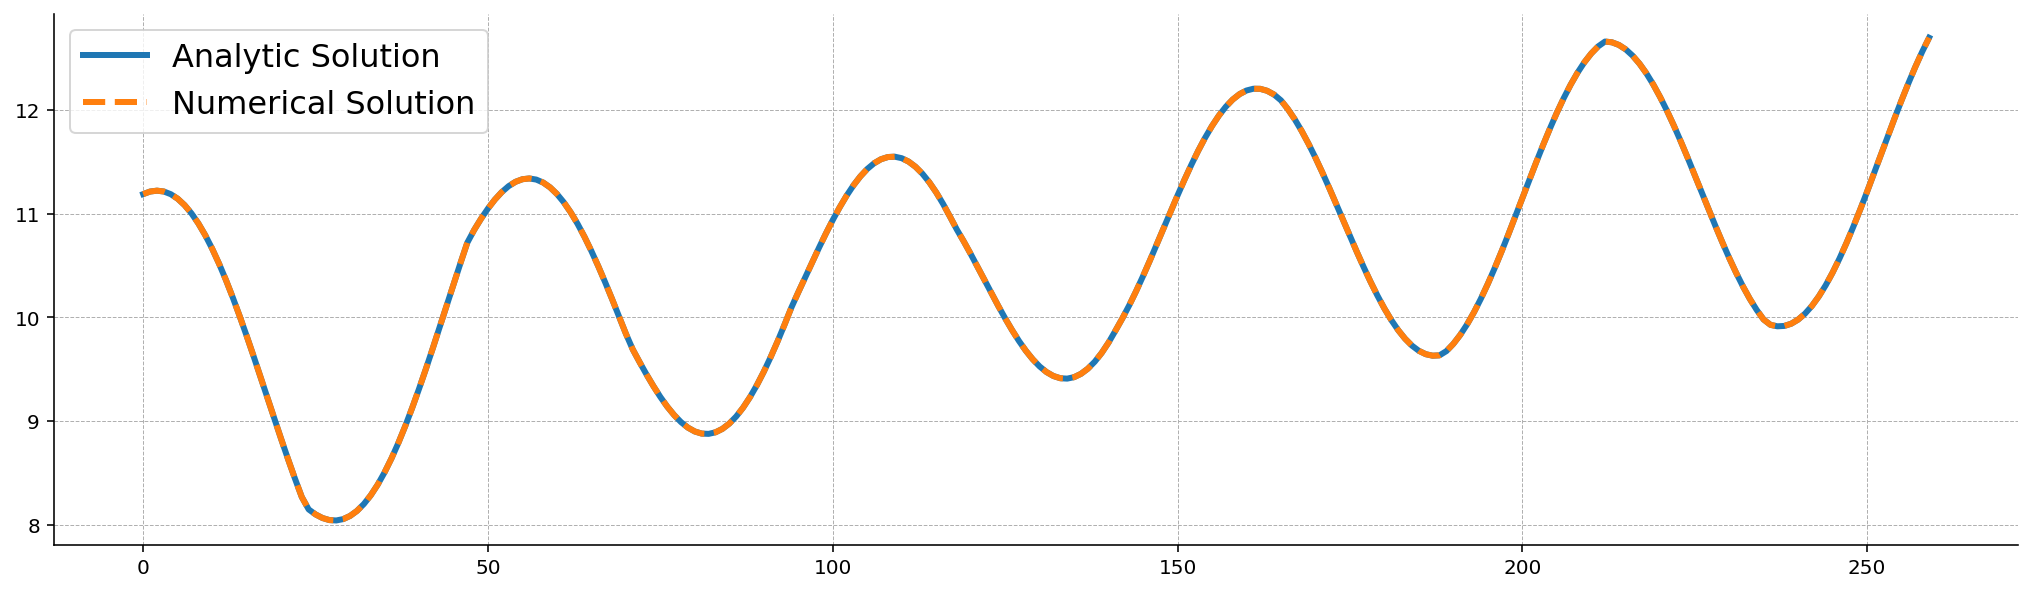

In [41]:
plt.plot(analytic_P_star, lw=3, label="Analytic Solution")
plt.plot(P_star, ls="--", lw=3, label="Numerical Solution")
plt.legend(fontsize=16)

# Repackage it nicely

In [42]:
from pytensor.tensor.subtensor import IncSubtensor


def cannonicalize_sales_expr(expr):
    fgraph = FunctionGraph(outputs=[expr], clone=False)

    distribute_mul_over_sub.rewrite(fgraph)
    MergeOptimizer().rewrite(fgraph)
    combine_addition_terms.rewrite(fgraph)
    return fgraph.outputs[0]


def find_exact_linear_solution(expr):
    P_star, success = None, None
    expr = cannonicalize_sales_expr(expr)

    a, b, price_ = var("a"), var("b"), var("price")
    pattern = etuple(pt.add, etuple(pt.mul, price_, a), b)

    for variant in yield_rewrite_variants(expr, rewrites):
        match_dict = unify(variant, pattern)
        if match_dict and match_dict[price_] is price:
            print("Found linear price function, using exact solution!")
            P_star = -match_dict[b] / match_dict[a]
            success = pt.as_tensor(np.array(True))
            break

    return P_star, success


def find_optimal_P_v2(P, Q, mc):
    pi = (Q * (P - mc)).sum()
    dpi_dP = pt.grad(pi, P)

    expr = rewrite_graph(dpi_dP, include=("canonicalize",))

    # Try for the exact solution
    P_star, success = find_exact_linear_solution(expr)

    # If we fail, fall back to a numerical optimizer
    if P_star is None:
        print("No exact solution avaiable, using numerical solver")
        P_star, success = root(expr, P, method="hybr", optimizer_kwargs=dict(tol=1e-8))

    return P_star, success

In [43]:
optimal_P, success = find_optimal_P_v2(price, expected_sales, mc)
P_star_fn = pytensor.function(
    [time, price, *params, mc], [optimal_P, success], on_unused_input="ignore"
)
profit_fn = pytensor.function(
    [price, sales, mc], sales * (price - mc), on_unused_input="ignore"
)

Found linear price function, using exact solution!


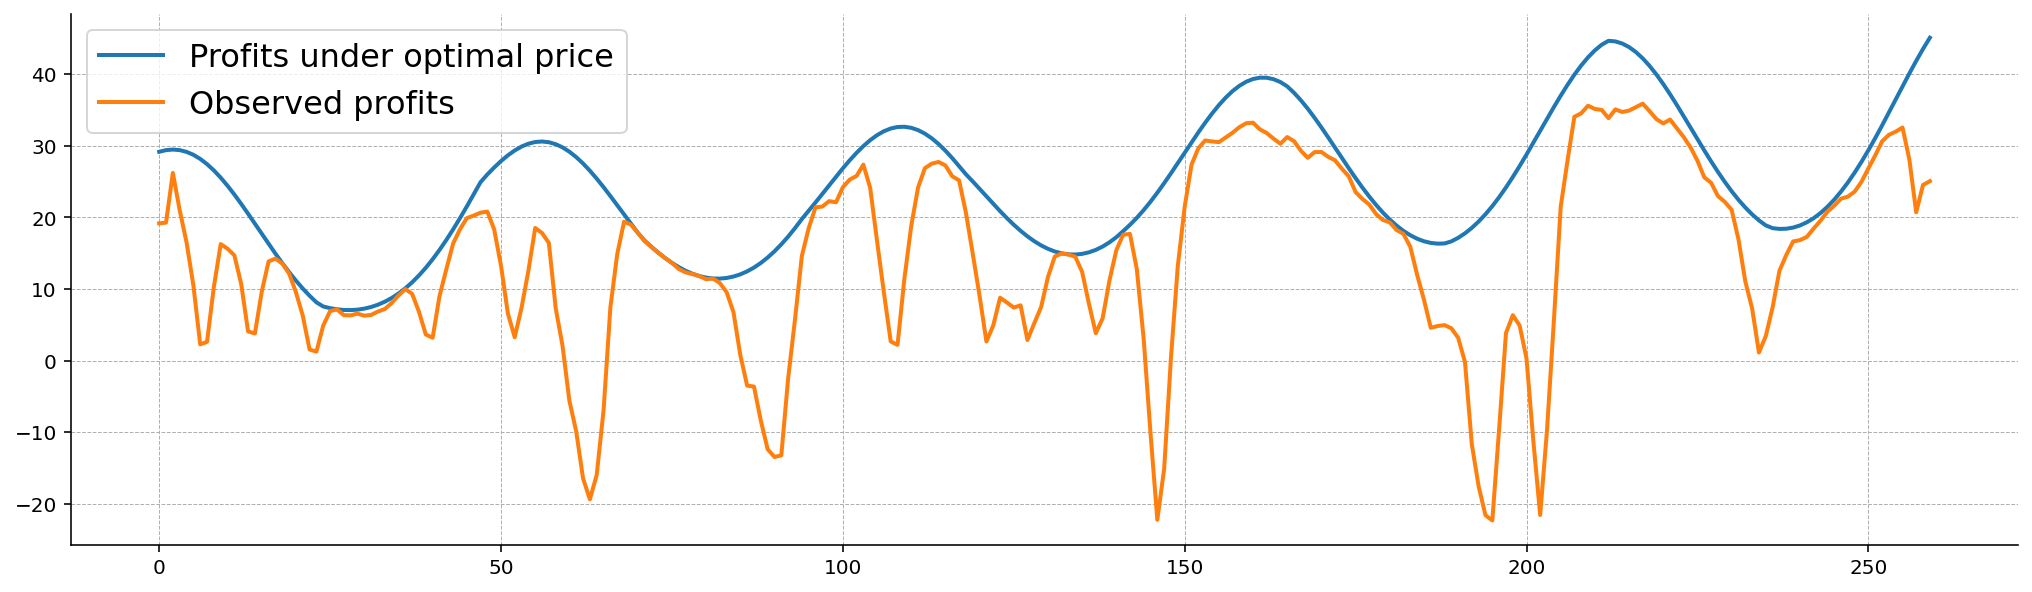

In [44]:
P_star, success_flag = P_star_fn(
    time_value, np.zeros_like(time_value), **optim_params, marginal_cost=5.0
)
Q_star = sales_fn(time_value, P_star, **optim_params)[0]

plt.plot(
    profit_fn(P_star, Q_star, marginal_cost=5.0),
    lw=2,
    label="Profits under optimal price",
)
plt.plot(
    profit_fn(
        prices_obs,
        sales_fn(time_value, prices_obs, **optim_params)[0],
        marginal_cost=5.0,
    ),
    lw=2,
    label="Observed profits",
)
plt.legend(fontsize=16)
plt.show()

## Handling Complex Scenarios



In [45]:
def find_optimal_P_v3(P, Q, mc):
    pi = (Q * (P - mc)).sum()
    choice_variable = P

    # Support the case where only a subset of P is being optimized, but only
    # if it is done using .set
    if P.owner:
        if not isinstance(P.owner.op, IncSubtensor):
            raise NotImplementedError()
        if not P.owner.op.set_instead_of_inc:
            raise NotImplementedError()
        choice_variable = P.owner.inputs[1]

        # If the value being set into P is not itself a root variable, we don't
        # know how to go deeper.
        if choice_variable.owner:
            raise NotImplementedError()

    # Whatever we found, optimize it
    dpi_dP = pt.grad(pi, choice_variable)

    expr = rewrite_graph(dpi_dP, include=("canonicalize",))

    P_star, success = find_exact_linear_solution(expr)

    if P_star is None:
        print("No exact solution avaiable, using numerical solver")
        P_star, success = root(
            expr, choice_variable, method="hybr", optimizer_kwargs=dict(tol=1e-8)
        )

    # If we optimized with respect to an input to P, sustitute the optimal value back into
    # the original P
    P_star = graph_replace(P, {choice_variable: P_star})

    return P_star, success

In [46]:
free_prices = pt.dvector("free_prices")
price_partially_fixed = price[100:250].set(free_prices)

sales_partially_fixed = graph_replace(expected_sales, {price: price_partially_fixed})

optimal_P_constrained, success = find_optimal_P_v3(
    price_partially_fixed, sales_partially_fixed, mc
)

P_star_constrained_fn = pytensor.function(
    [time, price, free_prices, *params, mc],
    [optimal_P_constrained, success],
    on_unused_input="ignore",
)

No exact solution avaiable, using numerical solver


In [47]:
P_star_constrained, _ = P_star_constrained_fn(
    time_value, prices_obs, np.zeros(150), **optim_params, marginal_cost=5.0
)
Q_star = sales_fn(time_value, P_star_constrained, **optim_params)[0]

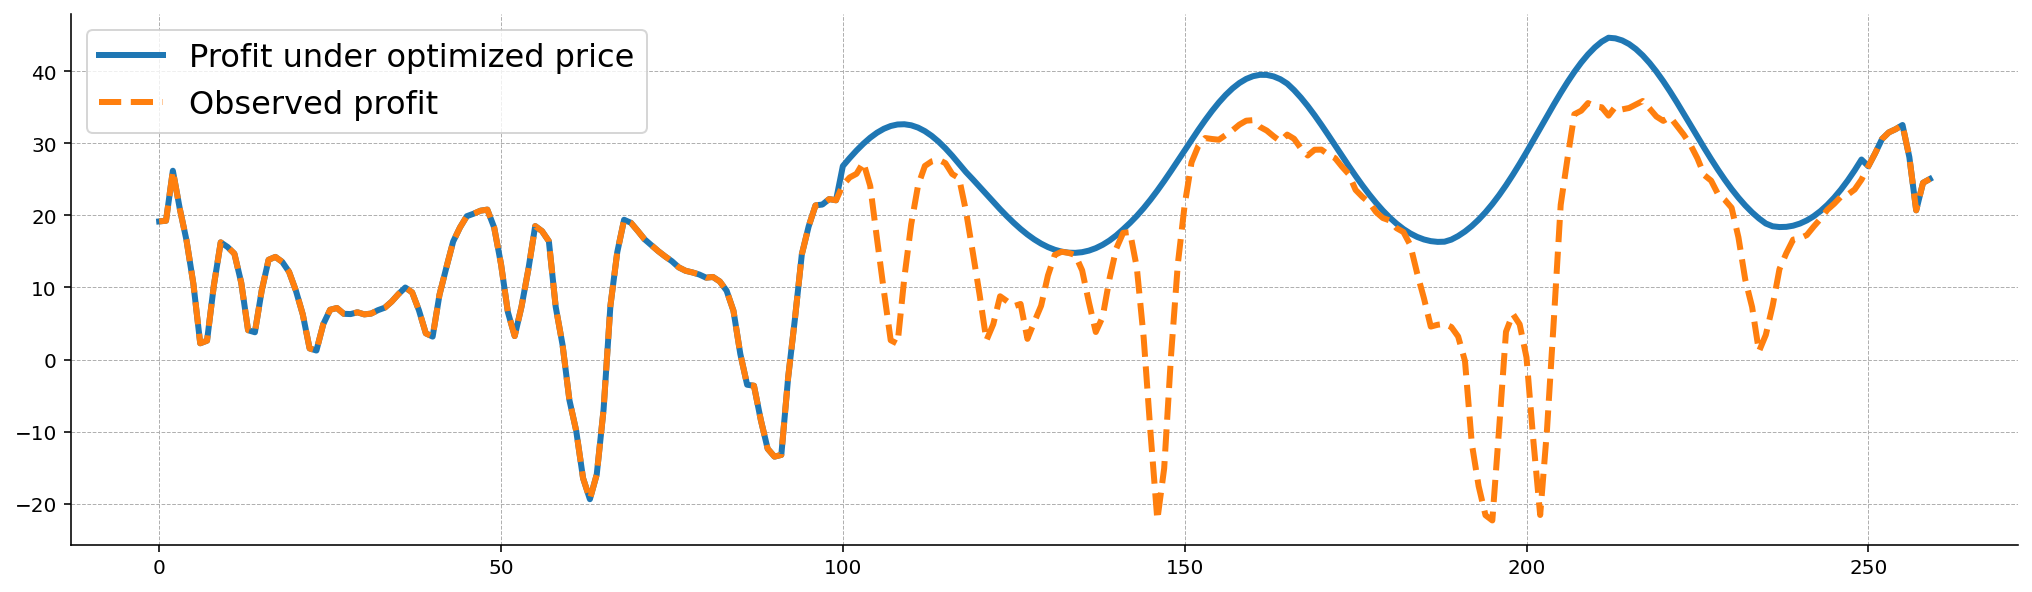

In [48]:
plt.plot(
    profit_fn(P_star_constrained, Q_star, marginal_cost=5.0),
    lw=3,
    label="Profit under optimized price",
)
plt.plot(
    profit_fn(
        prices_obs,
        sales_fn(time_value, prices_obs, **optim_params)[0],
        marginal_cost=5.0,
    ),
    lw=3,
    ls="--",
    label="Observed profit",
)
plt.legend(fontsize=16)
plt.show()